In [1]:
import os
import string
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, FreqDist
from nltk.stem import WordNetLemmatizer
from pattern.text.en import singularize
from sklearn.decomposition import NMF
import warnings

warnings.filterwarnings("ignore")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def CleanedTextColumn(df, columns_names):
    w_lem = WordNetLemmatizer()
    for column in columns_names:
        cleaned_str = []
        for text in df[column]:
            # split into words
            tokens = word_tokenize(text)
            # convert to lower case
            tokens = [w.lower() for w in tokens]
            # remove punctuation from each word
            table = str.maketrans('', '', string.punctuation)
            stripped = [w.translate(table) for w in tokens]
            # remove remaining tokens that are not alphabetic
            words = [word for word in stripped if word.isalpha()]
            stop_words = set(stopwords.words('english'))
            words = [w for w in words if not w in stop_words]
            treated_words = [w_lem.lemmatize(w) for w in words]
            s = ""
            for w in treated_words:
                s += w + " "
            cleaned_str.append(s[:-1])
        df[f"cleaned_{column}_str"] = cleaned_str
    return df

def GetAllNouns(t):
    if isinstance(t, str):
        tokens = word_tokenize(t)
    else:
        tokens = t
    tagged = pos_tag(tokens)
    all_nouns_tuple = [nouns for nouns in tagged if "NN" in nouns[1]]
    all_nouns = []
    for nouns in all_nouns_tuple:
        if len(nouns[0]) > 1:
            if nouns[1] == "NNS":
                all_nouns.append(singularize(nouns[0]))
            else:
                all_nouns.append(nouns[0])
    return all_nouns

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(p=pct,v=val)
    return my_autopct

def GetCountPapers(df, most_frequent_lst):
    lst = []
    for word, n in most_frequent_lst:
        counter = 0
        for abstract in df["cleaned_abstract_str"]:
            if word in abstract:
                counter += 1
        lst.append((word, n, counter))
    return lst

def MakeMatrices(df, w, h):
    h_df = pd.DataFrame(h, columns = df.columns, index = [f"component_{n}" for n in range(1, h.shape[0] + 1)])
    h_df.index.name = "components"
    w_df = pd.DataFrame(w, columns = [f"component_{n}" for n in range(1, h.shape[0] + 1)], index = df.index.to_list())
    w_df.index.name = "titles"
    return w_df, h_df

def SaveModel(df, w_df, h_df):
    if os.path.isfile(f"excels/matrices_n_components_{h_df.shape[0]}.xlsx"):
        print(f"File with name matrices_n_components_{h_df.shape[0]} already exists")
        if w_df == pd.read_excel(f"excels/matrices_n_components_{h_df.shape[0]}.xlsx", sheet_name="W"):
            print("W dataframes are equal")
        else:
            print("W dataframes are not equal")
        return
    writer = pd.ExcelWriter(f"excels/matrices_n_components{h_df.shape[0]}.xlsx", engine='xlsxwriter')
    df.to_excel(writer, "V")
    h_df.to_excel(writer, "H")
    w_df.to_excel(writer, "W")
    writer.save()
    print("Matrices saved")

def SaveComponents(df_h, n_topic):
    writer = pd.ExcelWriter("excels/ordered_components.xlsx", engine='xlsxwriter')
    for i in range(1, df_h.shape[0] + 1):
        helper_df = df_h[df_h.index == f"component_{i}"].sort_values(by=f"component_{i}", axis=1, ascending=False).copy()
        helper1_df = helper_df.iloc[:, :n_topic].copy()
        helper1_df.to_excel(writer, f"component_{i}")
    writer.save()
    print("Components saved")

# The data

In [3]:
df = pd.read_excel("excels/springer_link_data_with_discipline.xlsx", index_col = 0)
df

,article_type,title,link,abstract,author,date,year,n_citations,discipline
0,Article,Effects of Sports Betting Motivations on Sport...,https://link.springer.com/article/10.1007/s114...,Many earlier studies conducted on sports betti...,"Sevda Gökce Yüce,Arif Yüce,Hakan Katırcı,[…],A...",2021-06-07,2021,2.0,Medicine & Public Health
1,Article,Transformation of Sports Betting into a Rapid ...,https://link.springer.com/article/10.1007/s114...,There is an increasing trend for online sports...,"Adrian Parke,Jonathan Parke",2019-01-04,2019,13.0,Medicine & Public Health
2,Article,Sports-Embedded Gambling Promotions: A Study o...,https://link.springer.com/article/10.1007/s114...,"Community, media and government concerns have ...","Nerilee Hing,Matthew Lamont,[…],Peter Vitartas...",2014-11-25,2014,41.0,Medicine & Public Health
3,Article,A comparative content analysis of media report...,https://link.springer.com/article/10.1186/s128...,BackgroundHarmful gambling is a significant pu...,"Jennifer L. David,Samantha L. Thomas,Melanie R...",2017-11-14,2017,3.0,Medicine & Public Health
4,Article,Alcohol consumption and sports-betting among y...,https://link.springer.com/article/10.1186/s128...,BackgroundThe popularity of sports-betting is ...,"Stella Cheryl Nabifo,Jonathan Izudi,Francis Ba...",2021-02-16,2021,NaN,Medicine & Public Health
...,...,...,...,...,...,...,...,...,...
782,Article,Die Notwendigkeit einer Pflege naturwissenscha...,https://link.springer.com/article/10.1007/BF00...,NaN,Werner Kroebel,1963-01,1963,NaN,Life Sciences
783,Article,The asteroid and comet impact hazard: risk ass...,https://link.springer.com/article/10.1007/s001...,The impact of extraterrestrial matter onto Ear...,"Christian Gritzner,Kai Dürfeld,[…],Jan Kasper,...",2006-05-03,2006,11.0,Life Sciences
784,Article,A rational asymmetric reaction to news: eviden...,https://link.springer.com/article/10.1007/s111...,Using a large dataset of matches played betwee...,"Jason P. Berkowitz,Craig A. Depken II",2017-09-30,2017,2.0,Finance
785,Article,"Foresight 2.0 - Definition, overview & evaluation",https://link.springer.com/article/10.1007/s403...,This paper contains a definition of Foresight ...,"Jörg Schatzmann,René Schäfer,Frederik Eichelbaum",2013-08-09,2013,30.0,History


In [4]:
print(f"{df.shape[0]} Papers")

787 Papers


In [5]:
df.drop(columns="article_type", inplace = True)
df

,title,link,abstract,author,date,year,n_citations,discipline
0,Effects of Sports Betting Motivations on Sport...,https://link.springer.com/article/10.1007/s114...,Many earlier studies conducted on sports betti...,"Sevda Gökce Yüce,Arif Yüce,Hakan Katırcı,[…],A...",2021-06-07,2021,2.0,Medicine & Public Health
1,Transformation of Sports Betting into a Rapid ...,https://link.springer.com/article/10.1007/s114...,There is an increasing trend for online sports...,"Adrian Parke,Jonathan Parke",2019-01-04,2019,13.0,Medicine & Public Health
2,Sports-Embedded Gambling Promotions: A Study o...,https://link.springer.com/article/10.1007/s114...,"Community, media and government concerns have ...","Nerilee Hing,Matthew Lamont,[…],Peter Vitartas...",2014-11-25,2014,41.0,Medicine & Public Health
3,A comparative content analysis of media report...,https://link.springer.com/article/10.1186/s128...,BackgroundHarmful gambling is a significant pu...,"Jennifer L. David,Samantha L. Thomas,Melanie R...",2017-11-14,2017,3.0,Medicine & Public Health
4,Alcohol consumption and sports-betting among y...,https://link.springer.com/article/10.1186/s128...,BackgroundThe popularity of sports-betting is ...,"Stella Cheryl Nabifo,Jonathan Izudi,Francis Ba...",2021-02-16,2021,NaN,Medicine & Public Health
...,...,...,...,...,...,...,...,...
782,Die Notwendigkeit einer Pflege naturwissenscha...,https://link.springer.com/article/10.1007/BF00...,NaN,Werner Kroebel,1963-01,1963,NaN,Life Sciences
783,The asteroid and comet impact hazard: risk ass...,https://link.springer.com/article/10.1007/s001...,The impact of extraterrestrial matter onto Ear...,"Christian Gritzner,Kai Dürfeld,[…],Jan Kasper,...",2006-05-03,2006,11.0,Life Sciences
784,A rational asymmetric reaction to news: eviden...,https://link.springer.com/article/10.1007/s111...,Using a large dataset of matches played betwee...,"Jason P. Berkowitz,Craig A. Depken II",2017-09-30,2017,2.0,Finance
785,"Foresight 2.0 - Definition, overview & evaluation",https://link.springer.com/article/10.1007/s403...,This paper contains a definition of Foresight ...,"Jörg Schatzmann,René Schäfer,Frederik Eichelbaum",2013-08-09,2013,30.0,History


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787 entries, 0 to 786
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        787 non-null    object 
 1   link         787 non-null    object 
 2   abstract     766 non-null    object 
 3   author       776 non-null    object 
 4   date         787 non-null    object 
 5   year         787 non-null    int64  
 6   n_citations  720 non-null    float64
 7   discipline   787 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 55.3+ KB


## Select the papers that have abstract (abstract is not null)

In [7]:
data = df[df['abstract'].notna()]
data.reset_index(drop = True, inplace = True)
data

,title,link,abstract,author,date,year,n_citations,discipline
0,Effects of Sports Betting Motivations on Sport...,https://link.springer.com/article/10.1007/s114...,Many earlier studies conducted on sports betti...,"Sevda Gökce Yüce,Arif Yüce,Hakan Katırcı,[…],A...",2021-06-07,2021,2.0,Medicine & Public Health
1,Transformation of Sports Betting into a Rapid ...,https://link.springer.com/article/10.1007/s114...,There is an increasing trend for online sports...,"Adrian Parke,Jonathan Parke",2019-01-04,2019,13.0,Medicine & Public Health
2,Sports-Embedded Gambling Promotions: A Study o...,https://link.springer.com/article/10.1007/s114...,"Community, media and government concerns have ...","Nerilee Hing,Matthew Lamont,[…],Peter Vitartas...",2014-11-25,2014,41.0,Medicine & Public Health
3,A comparative content analysis of media report...,https://link.springer.com/article/10.1186/s128...,BackgroundHarmful gambling is a significant pu...,"Jennifer L. David,Samantha L. Thomas,Melanie R...",2017-11-14,2017,3.0,Medicine & Public Health
4,Alcohol consumption and sports-betting among y...,https://link.springer.com/article/10.1186/s128...,BackgroundThe popularity of sports-betting is ...,"Stella Cheryl Nabifo,Jonathan Izudi,Francis Ba...",2021-02-16,2021,NaN,Medicine & Public Health
...,...,...,...,...,...,...,...,...
761,Die Beziehung zwischen Nahrungsaufwand und kör...,https://link.springer.com/article/10.1007/BF01...,"1)Sitzungsber. d. Bayer. Akad. d. Wiss. 1885, ...",Max Rubner,1927-03,1927,2.0,Life Sciences
762,The asteroid and comet impact hazard: risk ass...,https://link.springer.com/article/10.1007/s001...,The impact of extraterrestrial matter onto Ear...,"Christian Gritzner,Kai Dürfeld,[…],Jan Kasper,...",2006-05-03,2006,11.0,Life Sciences
763,A rational asymmetric reaction to news: eviden...,https://link.springer.com/article/10.1007/s111...,Using a large dataset of matches played betwee...,"Jason P. Berkowitz,Craig A. Depken II",2017-09-30,2017,2.0,Finance
764,"Foresight 2.0 - Definition, overview & evaluation",https://link.springer.com/article/10.1007/s403...,This paper contains a definition of Foresight ...,"Jörg Schatzmann,René Schäfer,Frederik Eichelbaum",2013-08-09,2013,30.0,History


In [8]:
cleaned_data = CleanedTextColumn(data, ["title","abstract"])
cleaned_data

,title,link,abstract,author,date,year,n_citations,discipline,cleaned_title_str,cleaned_abstract_str
0,Effects of Sports Betting Motivations on Sport...,https://link.springer.com/article/10.1007/s114...,Many earlier studies conducted on sports betti...,"Sevda Gökce Yüce,Arif Yüce,Hakan Katırcı,[…],A...",2021-06-07,2021,2.0,Medicine & Public Health,effect sport betting motivation sport betting ...,many earlier study conducted sport betting add...
1,Transformation of Sports Betting into a Rapid ...,https://link.springer.com/article/10.1007/s114...,There is an increasing trend for online sports...,"Adrian Parke,Jonathan Parke",2019-01-04,2019,13.0,Medicine & Public Health,transformation sport betting rapid continuous ...,increasing trend online sport betting identifi...
2,Sports-Embedded Gambling Promotions: A Study o...,https://link.springer.com/article/10.1007/s114...,"Community, media and government concerns have ...","Nerilee Hing,Matthew Lamont,[…],Peter Vitartas...",2014-11-25,2014,41.0,Medicine & Public Health,sportsembedded gambling promotion study exposu...,community medium government concern emerged pr...
3,A comparative content analysis of media report...,https://link.springer.com/article/10.1186/s128...,BackgroundHarmful gambling is a significant pu...,"Jennifer L. David,Samantha L. Thomas,Melanie R...",2017-11-14,2017,3.0,Medicine & Public Health,comparative content analysis medium reporting ...,backgroundharmful gambling significant public ...
4,Alcohol consumption and sports-betting among y...,https://link.springer.com/article/10.1186/s128...,BackgroundThe popularity of sports-betting is ...,"Stella Cheryl Nabifo,Jonathan Izudi,Francis Ba...",2021-02-16,2021,NaN,Medicine & Public Health,alcohol consumption sportsbetting among young ...,backgroundthe popularity sportsbetting growing...
...,...,...,...,...,...,...,...,...,...,...
761,Die Beziehung zwischen Nahrungsaufwand und kör...,https://link.springer.com/article/10.1007/BF01...,"1)Sitzungsber. d. Bayer. Akad. d. Wiss. 1885, ...",Max Rubner,1927-03,1927,2.0,Life Sciences,die beziehung zwischen nahrungsaufwand und kör...,sitzungsber bayer akad wi undrubners gesetze d...
762,The asteroid and comet impact hazard: risk ass...,https://link.springer.com/article/10.1007/s001...,The impact of extraterrestrial matter onto Ear...,"Christian Gritzner,Kai Dürfeld,[…],Jan Kasper,...",2006-05-03,2006,11.0,Life Sciences,asteroid comet impact hazard risk assessment m...,impact extraterrestrial matter onto earth cont...
763,A rational asymmetric reaction to news: eviden...,https://link.springer.com/article/10.1007/s111...,Using a large dataset of matches played betwee...,"Jason P. Berkowitz,Craig A. Depken II",2017-09-30,2017,2.0,Finance,rational asymmetric reaction news evidence eng...,using large dataset match played two publicly ...
764,"Foresight 2.0 - Definition, overview & evaluation",https://link.springer.com/article/10.1007/s403...,This paper contains a definition of Foresight ...,"Jörg Schatzmann,René Schäfer,Frederik Eichelbaum",2013-08-09,2013,30.0,History,foresight definition overview evaluation,paper contains definition foresight summarizes...


# Data analysis

## Papers by year

In [9]:
cleaned_data.groupby("year").year.count()

year
1927     1
1938     2
1985     1
1987     1
1988     6
1989     3
1990     4
1991     1
1992     6
1993     6
1994     2
1995     4
1996     8
1997     5
1998     4
1999     1
2000     6
2001     4
2002     6
2003     4
2004    12
2005    13
2006    18
2007    22
2008    20
2009    27
2010    30
2011    23
2012    31
2013    47
2014    47
2015    45
2016    39
2017    57
2018    52
2019    72
2020    61
2021    75
Name: year, dtype: int64

In [10]:
np.sort(cleaned_data["year"].unique())

array([1927, 1938, 1985, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021], dtype=int64)

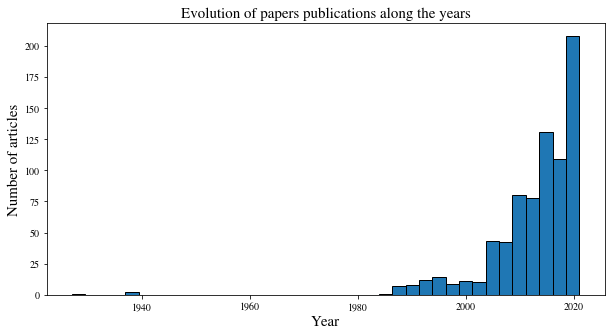

In [11]:
n_bins = len(cleaned_data["year"].unique())
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data["year"], bins = n_bins, ec = "black")
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Number of articles", fontsize = 15)
plt.title("Evolution of papers publications along the years", fontsize = 15)
plt.show()

### Checking the paper from 1927 and 1938

In [12]:
cleaned_data[cleaned_data["year"] <= 1938]


,title,link,abstract,author,date,year,n_citations,discipline,cleaned_title_str,cleaned_abstract_str
741,Zum Verhalten des Windkessels und des Peripher...,https://link.springer.com/article/10.1007/BF01...,\n\n\n1.\nMittels physikalischer Methoden werd...,"W. Herkel,P. D. Papageorgiou",1938-07,1938,1.0,Biomedicine,zum verhalten de windkessels und de peripheren...,mittels physikalischer methoden werden bei ges...
742,Über die Beeinflussung des Fusses durch seine ...,https://link.springer.com/article/10.1007/BF01...,"1A.Basler, Med. Klin.1936, Nr 46.2Abgebildet b...",Adolf Basler,1938-07,1938,NaN,Biomedicine,über die beeinflussung de fuss durch seine bek...,med nr beia altschafftel z orthop u google sch...
761,Die Beziehung zwischen Nahrungsaufwand und kör...,https://link.springer.com/article/10.1007/BF01...,"1)Sitzungsber. d. Bayer. Akad. d. Wiss. 1885, ...",Max Rubner,1927-03,1927,2.0,Life Sciences,die beziehung zwischen nahrungsaufwand und kör...,sitzungsber bayer akad wi undrubners gesetze d...


In [13]:
cleaned_data.drop(cleaned_data[cleaned_data["year"] <= 1938].index, inplace=True)
cleaned_data.reset_index(drop=True, inplace=True)

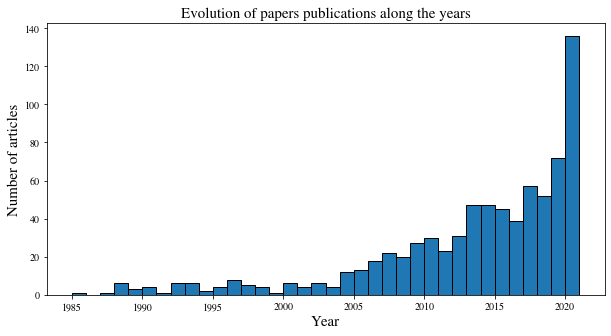

In [14]:
n_bins = len(cleaned_data["year"].unique())
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data["year"], bins = n_bins, ec = "black")
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Number of articles", fontsize = 15)
plt.title("Evolution of papers publications along the years", fontsize = 15)
plt.show()

In [15]:
cleaned_data[cleaned_data["year"] == cleaned_data["year"].min()].link.values[0]

'https://link.springer.com/article/10.1007/BF01019749'

## Papers by discipline

In [16]:
papers_discipline = cleaned_data.groupby("discipline").discipline.count().sort_values(ascending = False)
papers_discipline

discipline
Medicine & Public Health            573
Economics                            47
Business and Management              33
Law                                  26
Social Sciences                      19
Criminology and Criminal Justice     15
Psychology                           13
Computer Science                     11
Mathematics                           9
Philosophy                            5
Engineering                           4
Biomedicine                           4
Physics                               1
Life Sciences                         1
History                               1
Finance                               1
Name: discipline, dtype: int64

[]

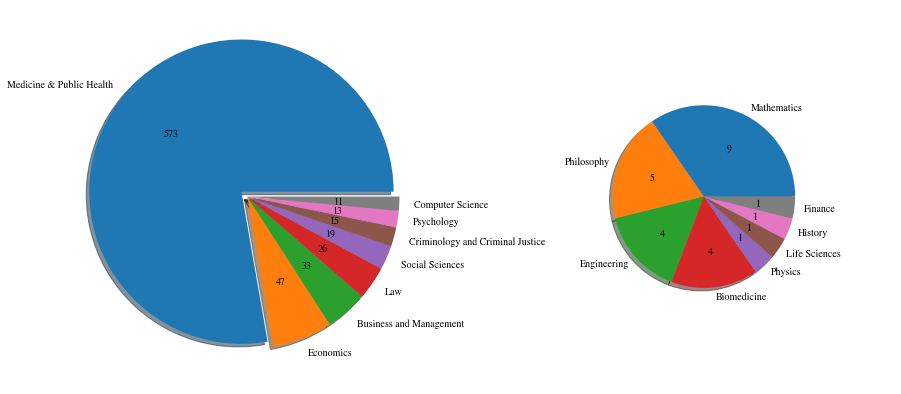

In [17]:
principal_pie = papers_discipline[ papers_discipline >= 10]
secondary_pie = papers_discipline[ papers_discipline < 10]
explode = [0 for i in range(len(principal_pie))]
explode[0] = 0.05
plt.figure(figsize=(15, 8), facecolor="1")
#plt.suptitle("Number of papers from different areas", fontsize = 20)
plt.subplot(1, 2, 1)
plt.pie(principal_pie.values, labels = principal_pie.index.to_list(), autopct = make_autopct(principal_pie), shadow = True, explode = explode)
plt.subplot(1, 2, 2)
plt.pie(secondary_pie.values, labels = secondary_pie.index.to_list(), autopct = make_autopct(secondary_pie), shadow = True, radius = 0.6)
plt.plot()
#plt.savefig("img/pie_chart_disciplinas", bbox_inches = "tight")

## Counting the nouns frequency in the abstracts

In [18]:
all_abstracts_str = ""
for abstract in cleaned_data["cleaned_abstract_str"]:
    all_abstracts_str += abstract + " "

In [19]:
all_nouns = GetAllNouns(all_abstracts_str)
frequency = FreqDist(all_nouns)
most_frequent_nouns = frequency.most_common(200)

In [20]:
lst_betting = GetCountPapers(cleaned_data, most_frequent_nouns)

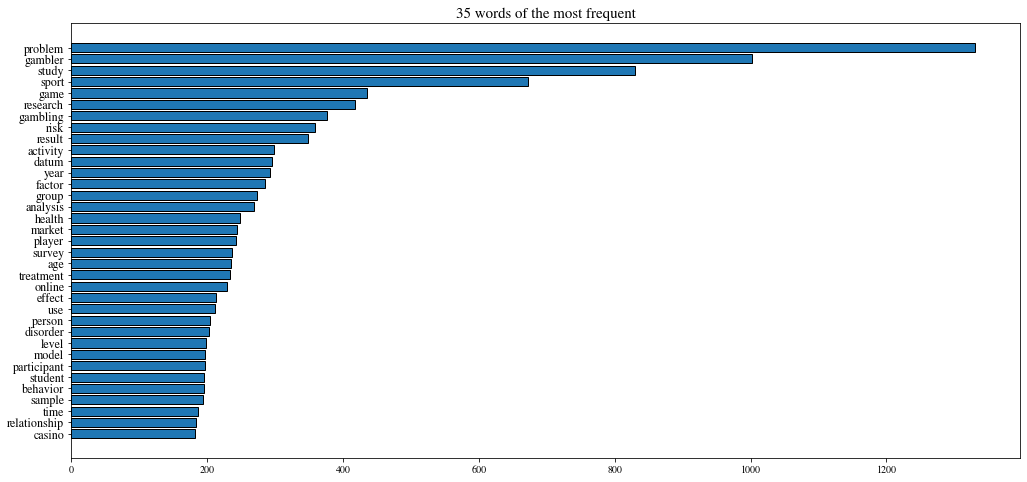

In [21]:
most_frequent_n = 35
most_frequent_for_plot = sorted( lst_betting[:most_frequent_n], key = lambda x: x[1])
plt.figure(figsize=(17, 8))
plt.barh(y = [word[0] for word in most_frequent_for_plot], width = [word[1] for word in most_frequent_for_plot], ec="black")
plt.yticks(size = 12)
plt.title(f"{most_frequent_n} words of the most frequent", fontsize = 15)
plt.show()
#plt.savefig("img/nomes_frequencia", bbox_inches = "tight")


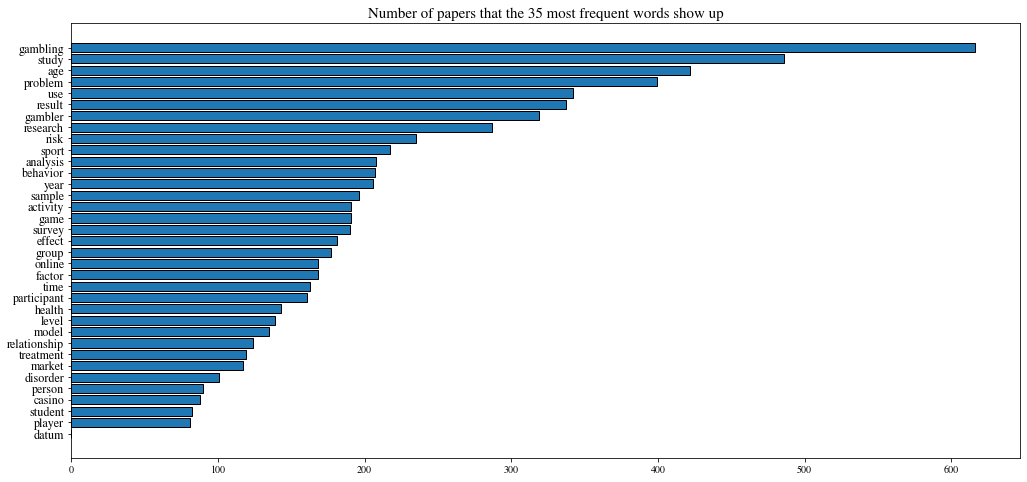

In [22]:
most_frequent_for_plot = sorted(lst_betting[:most_frequent_n], key = lambda x: x[2])
plt.figure(figsize=(17, 8))
plt.barh(y = [word[0] for word in most_frequent_for_plot], width = [word[2] for word in most_frequent_for_plot], ec="black")
plt.yticks(size = 12)
plt.title(f"Number of papers that the {most_frequent_n} most frequent words show up", fontsize = 15)
plt.show()
#plt.savefig("img/histograma_vezes_palavras_aparecem", bbox_inches = "tight")

## Comparing most frequent words from the first search to a thermodynamics search

With this the words that are normally more frequent in general papers will be ignored in order to study the most frequent in the first search

In [23]:
thermodynamics_df = pd.read_excel("excels/thermodynamics_articles.xlsx", index_col = 0)
thermodynamics_df

,article_type,title,link,abstract,author,date,year,n_citations,discipline
0,Article,"ExHFT-5, 5th World Conference on Experimental ...",https://link.springer.com/article/10.1007/s003...,NaN,,2000-06,2000,8.0,Engineering
1,Article,Call for Nominations – The Nusselt–Reynolds Pr...,https://link.springer.com/article/10.1007/s003...,NaN,,2000-08,2000,NaN,Engineering
2,Article,Call for Nominations The Nusselt-Reynolds Priz...,https://link.springer.com/article/10.1007/s002...,NaN,,2000-03,2000,NaN,Engineering
3,Article,Flow geometry optimization of channels with ba...,https://link.springer.com/article/10.1007/s004...,NaN,"T. Ayhan,B. Karlik,A. Tandiroglu",2008-04-26,2008,1.0,Engineering
4,Article,The Mechanics and Thermodynamics of Continuous...,https://link.springer.com/article/10.1023/A%3A...,NaN,Paolo Maria Mariano,1999-12,1999,NaN,Engineering
...,...,...,...,...,...,...,...,...,...
1034,Article,Stability of the equilibrium state for a hydro...,https://link.springer.com/article/10.1007/PL00...,"Lyapunov stability and, under a certain restr...","A. M. Blokhin,A. S. Bushmanova,V. Romano",2001-05,2001,3.0,Engineering
1035,Article,A thermodynamic framework to develop rate-type...,https://link.springer.com/article/10.1007/s007...,"1.Rajagopal K.R., Srinivasa A.R.: On the therm...","S. Karra,K. R. Rajagopal",2009-04-04,2009,13.0,Engineering
1036,Article,A thermo-micro-mechanical modeling for smart s...,https://link.springer.com/article/10.1007/s109...,This paper presents a theoretical study of the...,"Hossein Ali Sepiani,Asdollah Ghazavi",2008-10-11,2008,5.0,Engineering
1037,Article,Obituary – Clifford Ambrose Truesdell (1919–2000),https://link.springer.com/article/10.1023/A%3A...,NaN,Gianfranco Capriz,2000-09,2000,2.0,Engineering


In [24]:
thermodynamics_df.drop(columns="article_type", inplace = True)

In [25]:
comparison_df = thermodynamics_df[thermodynamics_df['abstract'].notna()]
comparison_df = comparison_df.sample(cleaned_data.shape[0], random_state=42)
comparison_df.reset_index(drop = True, inplace = True)

In [26]:
comparison_df = CleanedTextColumn(comparison_df, ["title", "abstract"])
comparison_df

,title,link,abstract,author,date,year,n_citations,discipline,cleaned_title_str,cleaned_abstract_str
0,Nonlinear electro-thermo-viscoelasticity,https://link.springer.com/article/10.1007/s007...,A coupled theory of nonlinear electro-thermo-v...,Xiaohong Chen,2009-09-03,2009,15.0,Engineering,nonlinear electrothermoviscoelasticity,coupled theory nonlinear electrothermoviscoela...
1,Thermodynamic analyses and optimization for th...,https://link.springer.com/article/10.1007/s114...,Thermoelectric effect is the most efficient wa...,"LinGen Chen,FanKai Meng,FengRui Sun",2016-01-13,2016,95.0,Engineering,thermodynamic analysis optimization thermoelec...,thermoelectric effect efficient way convert el...
2,Transport coefficients and pressure conditions...,https://link.springer.com/article/10.1007/s114...,"In this paper, the transport of sub-cooled wat...","S. Kjelstrup,S. A. Ghoreishian Amiri,B. Lorang...",2021-02-22,2021,NaN,Engineering,transport coefficient pressure condition growt...,paper transport subcooled water across partial...
3,Compressible generalized Newtonian fluids,https://link.springer.com/article/10.1007/s000...,We systematically derive models that would be ...,"J. Málek,K. R. Rajagopal",2010-03-02,2010,15.0,Engineering,compressible generalized newtonian fluid,systematically derive model would suitable des...
4,Intensive Studies for Modeling and Thermodynam...,https://link.springer.com/article/10.1007/s118...,"Mylonite rocks of the Abu Rusheid area, Southe...","Ahmed A. Eliwa,Ebrahim A. Gawad,[…],Amal E. Mu...",2021-08-17,2021,NaN,Engineering,intensive study modeling thermodynamics fusion...,mylonite rock abu rusheid area southeastern de...
...,...,...,...,...,...,...,...,...,...,...
758,A variational principle for fluid mechanics,https://link.springer.com/article/10.1007/BF00...,A variational principle for fluid mechanics is...,Ton Tran-Cong,1996-12,1996,2.0,Engineering,variational principle fluid mechanic,variational principle fluid mechanic derived w...
759,Remarks on continuum theory of mixtures: edito...,https://link.springer.com/article/10.1007/s125...,Models based on mixture theory allow for a sys...,"K. V. Mohankumar,Vít Průša,[…],K. Kannan,A. S....",2017-04-04,2017,NaN,Engineering,remark continuum theory mixture editorial spec...,model based mixture theory allow systematic st...
760,A review of higher order strain gradient theor...,https://link.springer.com/article/10.1007/s120...,In this paper we review developments in higher...,"SUMAN GUHA,SANDEEP SANGAL,SUMIT BASU",2015-07-10,2015,4.0,Engineering,review higher order strain gradient theory pla...,paper review development higher order strain g...
761,A determinate model of thrust-augmenting ejectors,https://link.springer.com/article/10.1007/BF00...,A theoretical analysis of the compressible flo...,"N. Whitley,A. Krothapalli,L. Van Dommelen",1996-01,1996,3.0,Engineering,determinate model thrustaugmenting ejector,theoretical analysis compressible flow constan...


In [27]:
all_abstracts_comparison_str = ""
for abstract in comparison_df["cleaned_abstract_str"]:
    all_abstracts_comparison_str += abstract + " "

In [28]:
all_nouns_comparison = GetAllNouns(all_abstracts_comparison_str)

In [29]:
frequency_comparison = FreqDist(all_nouns_comparison)

### Getting the 200 most common words for the comparison

In [30]:
most_frequent_nouns_comparison = frequency_comparison.most_common(200)

In [31]:
lst_comparison = GetCountPapers(comparison_df, most_frequent_nouns_comparison)

### Frequent words comparison

In [32]:
nouns_in_common = []
l = []
for noun, freq, n_times in lst_betting:
    for noun_comparison, freq_comparison, n_times_comparison in lst_comparison:
        if noun == noun_comparison:
            nouns_in_common.append((noun, freq / len(all_abstracts_str), freq_comparison / len(all_abstracts_comparison_str), (n_times / cleaned_data.shape[0]) * 100, (n_times_comparison / cleaned_data.shape[0]) * 100))
            l.append(noun)
            break

for w in list(set([w[0] for w in lst_betting]) - set(l)):
    for noun, freq, n_times in lst_betting:
        if w == noun:
            nouns_in_common.append((noun, freq / len(all_abstracts_str), 0, (n_times / cleaned_data.shape[0]) * 100, 0))
            break

nouns_in_common = sorted(nouns_in_common, key=lambda x: x[1], reverse=True)

In [33]:
words_df = pd.DataFrame(nouns_in_common, columns=["Word", "Frequency in the sports betting search", "Frequency in the thermo search", "Number of papers that include the word in sports betting search", "Number of papers that include the word in thermo search"])
words_df

,Word,Frequency in the sports betting search,Frequency in the thermo search,Number of papers that include the word in sports betting search,Number of papers that include the word in thermo search
0,problem,0.001687,0.000210,52.293578,13.106160
1,gambler,0.001271,0.000000,41.808650,0.000000
2,study,0.001053,0.000344,63.695937,20.576671
3,sport,0.000852,0.000000,28.440367,0.000000
4,game,0.000553,0.000000,25.032765,0.000000
...,...,...,...,...,...
195,part,0.000063,0.000188,50.720839,24.377457
196,female,0.000063,0.000000,10.747051,0.000000
197,technology,0.000062,0.000055,4.193971,2.883355
198,journal,0.000062,0.000000,2.228047,0.000000


In [34]:
principal_words_df = words_df[(words_df["Number of papers that include the word in sports betting search"] >= 5) & (words_df["Number of papers that include the word in thermo search"] == 0)].copy()
principal_words_df.reset_index(drop=True, inplace=True)
principal_words_df

,Word,Frequency in the sports betting search,Frequency in the thermo search,Number of papers that include the word in sports betting search,Number of papers that include the word in thermo search
0,gambler,0.001271,0.0,41.808650,0.0
1,sport,0.000852,0.0,28.440367,0.0
2,game,0.000553,0.0,25.032765,0.0
3,gambling,0.000478,0.0,80.733945,0.0
4,risk,0.000454,0.0,30.799476,0.0
...,...,...,...,...,...
125,need,0.000066,0.0,18.610747,0.0
126,ass,0.000065,0.0,50.982962,0.0
127,gaming,0.000065,0.0,11.926606,0.0
128,skill,0.000065,0.0,6.290957,0.0


In [35]:
bag_of_words = principal_words_df["Word"].values #np.delete(principal_words_df["Word"].values, np.where(principal_words_df["Word"].values == "ad"))
print(len(bag_of_words))
bag_of_words

130


array(['gambler', 'sport', 'game', 'gambling', 'risk', 'year', 'group',
       'health', 'market', 'player', 'survey', 'age', 'online', 'person',
       'disorder', 'level', 'participant', 'student', 'sample', 'casino',
       'machine', 'strategy', 'severity', 'lottery', 'harm',
       'participation', 'measure', 'adult', 'impact', 'population',
       'prevalence', 'adolescent', 'frequency', 'intervention',
       'internet', 'control', 'information', 'money', 'community',
       'association', 'issue', 'poker', 'policy', 'behaviour', 'alcohol',
       'youth', 'experience', 'limit', 'evidence', 'prevention', 'bettor',
       'addiction', 'outcome', 'male', 'play', 'family', 'bet', 'program',
       'event', 'involvement', 'child', 'gender', 'index', 'predictor',
       'service', 'report', 'attitude', 'substance', 'practice',
       'support', 'literature', 'questionnaire', 'examine', 'aim',
       'month', 'review', 'industry', 'man', 'consumption', 'exposure',
       'role', 'cons

In [36]:
matrix = []
for v in cleaned_data[["title","cleaned_abstract_str"]].values:
    vector = [0 for _ in range(len(bag_of_words))]
    for i, word in enumerate(bag_of_words):
        if word in v[1]:
            vector[i] = 1
    matrix.append([v[0]] + vector)
matrix_df = pd.DataFrame(matrix, columns=["title"] + list(bag_of_words))
matrix_df.set_index("title", inplace=True)
#matrix_df.to_excel("matrix.xlsx")

In [37]:
n_components = 10
model = NMF(n_components, random_state = 42)
W = model.fit_transform(matrix_df)
H = model.components_
df_W, df_H = MakeMatrices(matrix_df, W, H)
#SaveModel(matrix_df, W, H)

In [38]:
def plot_top_words(df_h, n, title, save = False):
    fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharex=True)

    axes = axes.flatten()
    for topic_idx in range(df_h.shape[0]):
        helper_df = df_h[df_h.index == f"component_{topic_idx + 1}"].sort_values(by=f"component_{topic_idx + 1}", axis=1).copy()
        helper1_df = helper_df.iloc[:, -n:].copy()

        ax = axes[topic_idx]
        ax.barh(helper1_df.columns.to_list(), helper1_df.iloc[0 , :].values, height = 0.5)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 16})
        ax.tick_params(axis="both", which="major", labelsize=17)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(f"{title} (n_components = {df_h.shape[0]}; n_top_words = {n})", fontsize = 20)

    plt.subplots_adjust(wspace=0.90, hspace=0.3)
    plt.savefig(f"img/NMF_n_components_{df_h.shape[0]}_n_words_{n}", bbox_inches = "tight") if save else plt.show()

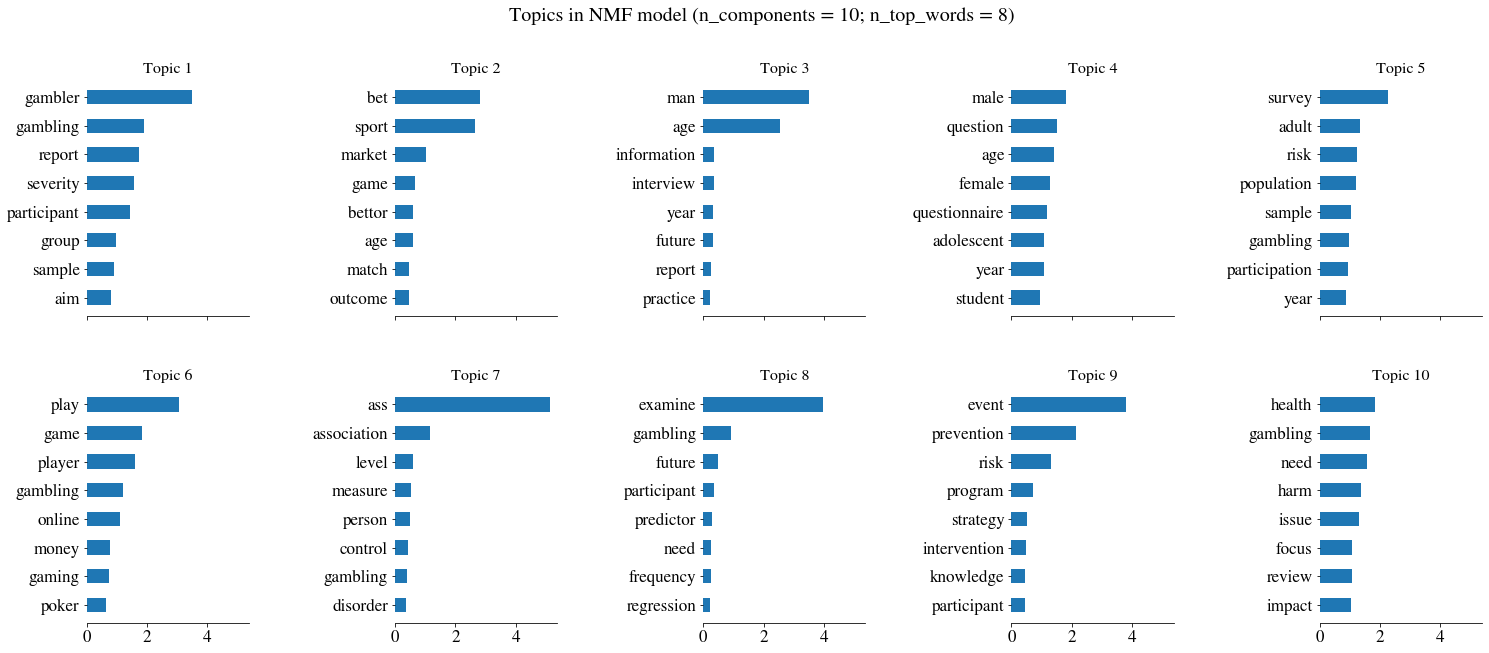

In [39]:
plot_top_words(df_H, 8, "Topics in NMF model")#, save=True)

## Focus on topics like Economics, Computer Science, Engineering and Mathmatics

In [40]:
cleaned_data.discipline.unique()

array(['Medicine & Public Health', 'Economics', 'Business and Management',
       'Law', 'Criminology and Criminal Justice', 'Social Sciences',
       'Psychology', 'Computer Science', 'Biomedicine', 'Mathematics',
       'Philosophy', 'Engineering', 'Life Sciences', 'Finance', 'History',
       'Physics'], dtype=object)

In [41]:
cleaned_data.drop(cleaned_data[~cleaned_data['discipline'].isin(["Economics", "Computer Science", "Mathematics", "Engineering"])].index, inplace=True)
cleaned_data

,title,link,abstract,author,date,year,n_citations,discipline,cleaned_title_str,cleaned_abstract_str
573,"Legalized Sports Betting, VLT Gambling, and St...",https://link.springer.com/article/10.1057/s413...,A Supreme Court decision legalizing sports bet...,Brad R. Humphreys,2021-01-04,2021,4.0,Economics,legalized sport betting vlt gambling state gam...,supreme court decision legalizing sport bettin...
574,The state of research on markets for sports be...,https://link.springer.com/article/10.1007/BF02...,Studies of markets for sports betting can be a...,Raymond D. Sauer,2005-09,2005,28.0,Economics,state research market sport betting suggested ...,study market sport betting rich source knowled...
575,Integrity Fees in Sports Betting Markets,https://link.springer.com/article/10.1057/s413...,Sports leagues have requested state legislatur...,"Craig A. Depken II,John M. Gandar",2021-01-04,2021,1.0,Economics,integrity fee sport betting market,sport league requested state legislature pas s...
576,Household consumption decisions: will expandin...,https://link.springer.com/article/10.1007/s111...,We use data from the Canadian Survey of Househ...,"Brad R. Humphreys,Jane E. Ruseski,Jie Yang",2019-12-11,2019,1.0,Economics,household consumption decision expanding sport...,use data canadian survey household spending an...
577,College Football Referee Bias and Sports Betti...,https://link.springer.com/article/10.1057/s413...,Conferences entrust college football referees ...,"Rhett Brymer,Ryan M. Rodenberg,[…],Huimiao Zhe...",2021-01-08,2021,1.0,Economics,college football referee bias sport betting im...,conference entrust college football referee im...
...,...,...,...,...,...,...,...,...,...,...
749,The value of statistical thinking: A basketbal...,https://link.springer.com/article/10.1007/s001...,"Breiter, D.J., and Carlin, B.P. (1997) “How to...",Phillip Price,2009-02-12,2009,NaN,Mathematics,value statistical thinking basketball gambling...,breiter dj carlin bp play office pool must cha...
755,Predicting the Outcome of a Tennis Tournament:...,https://link.springer.com/article/10.1007/s115...,This paper is about predicting the outcome of ...,"Wei Gu,Thomas L. Saaty",2019-06-06,2019,4.0,Engineering,predicting outcome tennis tournament based dat...,paper predicting outcome tennis match associat...
756,Badminton match outcome prediction model using...,https://link.springer.com/article/10.1007/s126...,The recent growth in the field of data mining ...,"Manoj Sharma, Monika,[…],Naresh Kumar,Pardeep ...",2020-10-04,2020,3.0,Engineering,badminton match outcome prediction model using...,recent growth field data mining machine learni...
757,A comparative study of different acceleration ...,https://link.springer.com/article/10.1186/s136...,"At present, there are many acceleration sensor...","Qixia Jia,Zengyin Yan,Yongyong Wang",2021-11-09,2021,NaN,Engineering,comparative study different acceleration senso...,present many acceleration sensor measuring hum...


In [42]:
papers_discipline_2 = cleaned_data.groupby("discipline").discipline.count().sort_values(ascending = False)
papers_discipline_2

discipline
Economics           47
Computer Science    11
Mathematics          9
Engineering          4
Name: discipline, dtype: int64

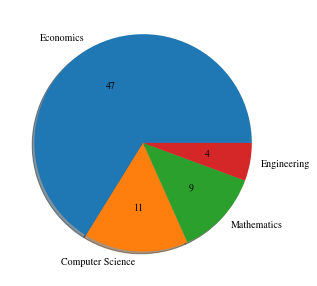

In [43]:
plt.figure(figsize=(13, 5), facecolor="1")
plt.pie(papers_discipline_2.values, labels = papers_discipline_2.index.to_list(), autopct = make_autopct(papers_discipline_2), shadow = True)
plt.show()

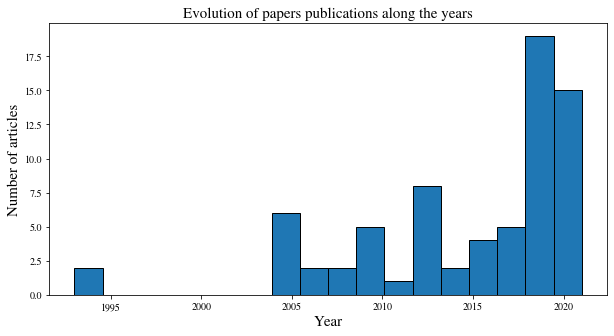

In [44]:
n_bins = len(cleaned_data["year"].unique())
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data["year"], bins = n_bins, ec = "black")
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Number of articles", fontsize = 15)
plt.title("Evolution of papers publications along the years", fontsize = 15)
plt.show()

In [45]:
cleaned_data[cleaned_data["year"] == cleaned_data["year"].min()].title.values[0]

'The utility of gambling'

In [46]:
cleaned_data[cleaned_data["year"] == cleaned_data["year"].min()].abstract.values[0]

"A tiny utility of gambling is appended to an expected utility model for a risk-averse individual. It is shown that the model can explain small payoff gambles, large prize lotteries, and patterns of risk-seeking in the experimental evidence that are puzzling from the viewpoint of standard theory. At the same time, the model maintains expected utility theory's ability to explain insurance purchase, portfolio diversification, and other risk-averting behavior. The tiny utility of gambling could equally well be appended to models of risky choice other than the expected utility model."

In [48]:
cleaned_data

,title,link,abstract,author,date,year,n_citations,discipline,cleaned_title_str,cleaned_abstract_str
573,"Legalized Sports Betting, VLT Gambling, and St...",https://link.springer.com/article/10.1057/s413...,A Supreme Court decision legalizing sports bet...,Brad R. Humphreys,2021-01-04,2021,4.0,Economics,legalized sport betting vlt gambling state gam...,supreme court decision legalizing sport bettin...
574,The state of research on markets for sports be...,https://link.springer.com/article/10.1007/BF02...,Studies of markets for sports betting can be a...,Raymond D. Sauer,2005-09,2005,28.0,Economics,state research market sport betting suggested ...,study market sport betting rich source knowled...
575,Integrity Fees in Sports Betting Markets,https://link.springer.com/article/10.1057/s413...,Sports leagues have requested state legislatur...,"Craig A. Depken II,John M. Gandar",2021-01-04,2021,1.0,Economics,integrity fee sport betting market,sport league requested state legislature pas s...
576,Household consumption decisions: will expandin...,https://link.springer.com/article/10.1007/s111...,We use data from the Canadian Survey of Househ...,"Brad R. Humphreys,Jane E. Ruseski,Jie Yang",2019-12-11,2019,1.0,Economics,household consumption decision expanding sport...,use data canadian survey household spending an...
577,College Football Referee Bias and Sports Betti...,https://link.springer.com/article/10.1057/s413...,Conferences entrust college football referees ...,"Rhett Brymer,Ryan M. Rodenberg,[…],Huimiao Zhe...",2021-01-08,2021,1.0,Economics,college football referee bias sport betting im...,conference entrust college football referee im...
...,...,...,...,...,...,...,...,...,...,...
749,The value of statistical thinking: A basketbal...,https://link.springer.com/article/10.1007/s001...,"Breiter, D.J., and Carlin, B.P. (1997) “How to...",Phillip Price,2009-02-12,2009,NaN,Mathematics,value statistical thinking basketball gambling...,breiter dj carlin bp play office pool must cha...
755,Predicting the Outcome of a Tennis Tournament:...,https://link.springer.com/article/10.1007/s115...,This paper is about predicting the outcome of ...,"Wei Gu,Thomas L. Saaty",2019-06-06,2019,4.0,Engineering,predicting outcome tennis tournament based dat...,paper predicting outcome tennis match associat...
756,Badminton match outcome prediction model using...,https://link.springer.com/article/10.1007/s126...,The recent growth in the field of data mining ...,"Manoj Sharma, Monika,[…],Naresh Kumar,Pardeep ...",2020-10-04,2020,3.0,Engineering,badminton match outcome prediction model using...,recent growth field data mining machine learni...
757,A comparative study of different acceleration ...,https://link.springer.com/article/10.1186/s136...,"At present, there are many acceleration sensor...","Qixia Jia,Zengyin Yan,Yongyong Wang",2021-11-09,2021,NaN,Engineering,comparative study different acceleration senso...,present many acceleration sensor measuring hum...


In [49]:
all_abstracts_str = ""
for abstract in cleaned_data["cleaned_abstract_str"]:
    all_abstracts_str += abstract + " "
all_nouns = GetAllNouns(all_abstracts_str)
frequency = FreqDist(all_nouns)
most_frequent_nouns = frequency.most_common(200)
lst_betting = GetCountPapers(cleaned_data, most_frequent_nouns)

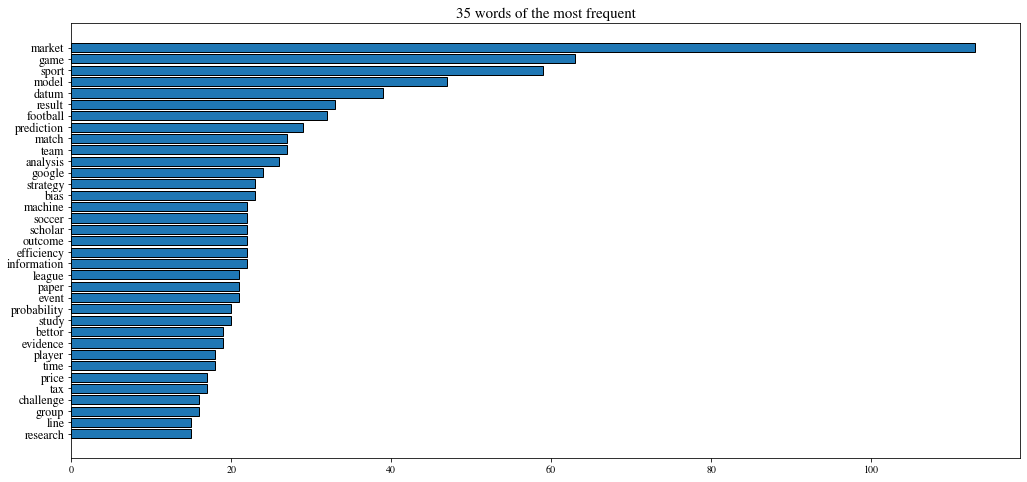

In [50]:
most_frequent_n = 35
most_frequent_for_plot = sorted( lst_betting[:most_frequent_n], key = lambda x: x[1])
plt.figure(figsize=(17, 8))
plt.barh(y = [word[0] for word in most_frequent_for_plot], width = [word[1] for word in most_frequent_for_plot], ec="black")
plt.yticks(size = 12)
plt.title(f"{most_frequent_n} words of the most frequent", fontsize = 15)
plt.show()
#plt.savefig("img/nomes_frequencia", bbox_inches = "tight")

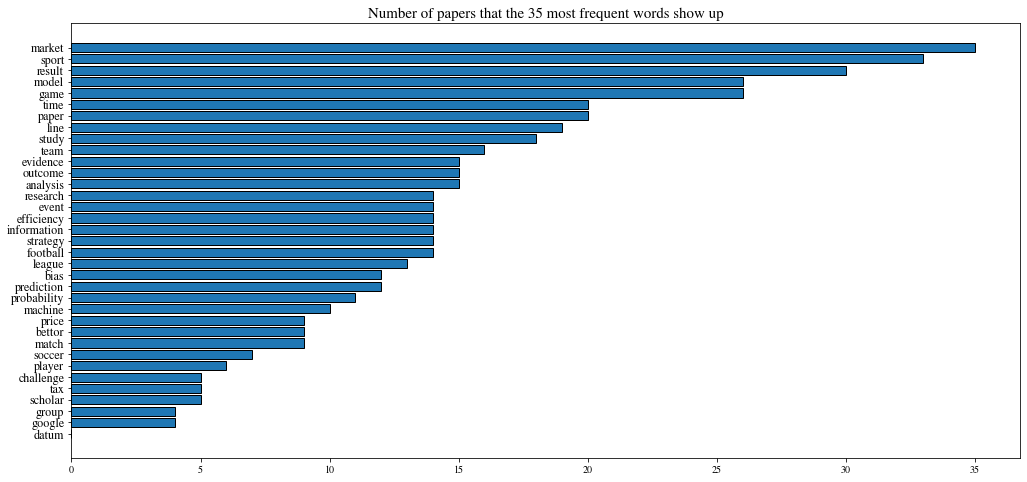

In [51]:
most_frequent_for_plot = sorted(lst_betting[:most_frequent_n], key = lambda x: x[2])
plt.figure(figsize=(17, 8))
plt.barh(y = [word[0] for word in most_frequent_for_plot], width = [word[2] for word in most_frequent_for_plot], ec="black")
plt.yticks(size = 12)
plt.title(f"Number of papers that the {most_frequent_n} most frequent words show up", fontsize = 15)
plt.show()
#plt.savefig("img/histograma_vezes_palavras_aparecem", bbox_inches = "tight")

In [52]:
nouns_in_common = []
l = []
for noun, freq, n_times in lst_betting:
    for noun_comparison, freq_comparison, n_times_comparison in lst_comparison:
        if noun == noun_comparison:
            nouns_in_common.append((noun, freq / len(all_abstracts_str), freq_comparison / len(all_abstracts_comparison_str), (n_times / cleaned_data.shape[0]) * 100, (n_times_comparison / cleaned_data.shape[0]) * 100))
            l.append(noun)
            break

for w in list(set([w[0] for w in lst_betting]) - set(l)):
    for noun, freq, n_times in lst_betting:
        if w == noun:
            nouns_in_common.append((noun, freq / len(all_abstracts_str), 0, (n_times / cleaned_data.shape[0]) * 100, 0))
            break

nouns_in_common = sorted(nouns_in_common, key=lambda x: x[1], reverse=True)

words_df = pd.DataFrame(nouns_in_common, columns=["Word", "Frequency in the sports betting search", "Frequency in the thermo search", "Number of papers that include the word in sports betting search", "Number of papers that include the word in thermo search"])
words_df

,Word,Frequency in the sports betting search,Frequency in the thermo search,Number of papers that include the word in sports betting search,Number of papers that include the word in thermo search
0,market,0.002194,0.000000,49.295775,0.000000
1,game,0.001223,0.000000,36.619718,0.000000
2,sport,0.001146,0.000000,46.478873,0.000000
3,model,0.000913,0.000999,36.619718,428.169014
4,datum,0.000757,0.000181,0.000000,0.000000
...,...,...,...,...,...
195,gambling,0.000078,0.000000,23.943662,0.000000
196,movement,0.000078,0.000000,4.225352,0.000000
197,implication,0.000078,0.000000,5.633803,0.000000
198,bce,0.000078,0.000000,1.408451,0.000000


In [53]:
principal_words_df = words_df[(words_df["Number of papers that include the word in sports betting search"] >= 5) & (words_df["Number of papers that include the word in thermo search"] == 0)].copy()
principal_words_df.reset_index(drop=True, inplace=True)
principal_words_df

,Word,Frequency in the sports betting search,Frequency in the thermo search,Number of papers that include the word in sports betting search,Number of papers that include the word in thermo search
0,market,0.002194,0.0,49.295775,0.0
1,game,0.001223,0.0,36.619718,0.0
2,sport,0.001146,0.0,46.478873,0.0
3,football,0.000621,0.0,19.718310,0.0
4,team,0.000524,0.0,22.535211,0.0
...,...,...,...,...,...
94,ad,0.000078,0.0,74.647887,0.0
95,conclude,0.000078,0.0,5.633803,0.0
96,way,0.000078,0.0,8.450704,0.0
97,gambling,0.000078,0.0,23.943662,0.0


In [54]:
bag_of_words = principal_words_df["Word"].values #np.delete(principal_words_df["Word"].values, np.where(principal_words_df["Word"].values == "ad"))
print(len(bag_of_words))
bag_of_words

99


array(['market', 'game', 'sport', 'football', 'team', 'match', 'bias',
       'strategy', 'outcome', 'information', 'machine', 'soccer', 'event',
       'league', 'probability', 'bettor', 'evidence', 'player', 'tax',
       'price', 'group', 'challenge', 'line', 'college', 'accuracy',
       'profit', 'trading', 'season', 'revenue', 'decision', 'trader',
       'basketball', 'book', 'stock', 'bet', 'consumption', 'measure',
       'spread', 'lottery', 'question', 'knowledge', 'feature', 'chance',
       'year', 'return', 'goal', 'income', 'level', 'world', 'journal',
       'policy', 'maker', 'task', 'inefficiency', 'art', 'economic',
       'home', 'cost', 'examine', 'rating', 'amount', 'survey',
       'tournament', 'preference', 'household', 'video', 'odd',
       'profitability', 'literature', 'impact', 'association', 'risk',
       'university', 'hand', 'trade', 'role', 'future', 'win', 'man',
       'context', 'option', 'dataset', 'limit', 'estimate', 'rule',
       'experience',

In [55]:
matrix = []
for v in cleaned_data[["title","cleaned_abstract_str"]].values:
    vector = [0 for _ in range(len(bag_of_words))]
    for i, word in enumerate(bag_of_words):
        if word in v[1]:
            vector[i] = 1
    matrix.append([v[0]] + vector)
matrix_df = pd.DataFrame(matrix, columns=["title"] + list(bag_of_words))
matrix_df.set_index("title", inplace=True)
#matrix_df.to_excel("matrix.xlsx")

In [56]:
n_components = 10
model = NMF(n_components, random_state = 42)
W = model.fit_transform(matrix_df)
H = model.components_
df_W, df_H = MakeMatrices(matrix_df, W, H)

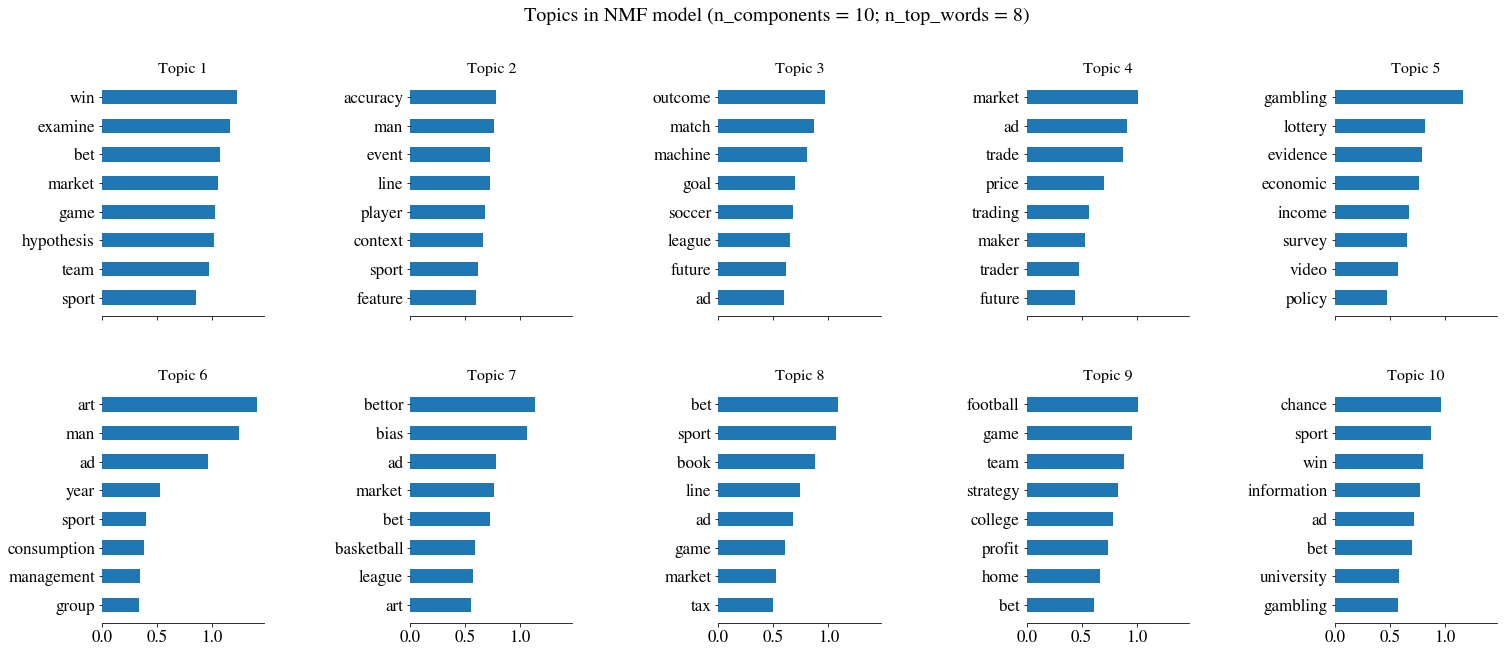

In [57]:
plot_top_words(df_H, 8, "Topics in NMF model")#, save=True)

In [58]:
df_W.sort_values(["component_3"], ascending=False).iloc[:20, :]

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
titles,,,,,,,,,,
The Open International Soccer Database for machine learning,0.069788,0.000000,1.448362,0.000000,0.006922,0.000000,0.000000,0.001082,0.191877,0.056296
Learning to predict soccer results from relational data with gradient boosted trees,0.000000,0.028033,1.299392,0.032331,0.000000,0.049508,0.000000,0.000000,0.000000,0.065538
Incorporating domain knowledge in machine learning for soccer outcome prediction,0.000000,0.404275,1.084621,0.000000,0.000000,0.087649,0.000000,0.000000,0.000000,0.000000
Machine-Learning-Based Statistical Arbitrage Football Betting,0.000000,0.000000,0.737049,0.445490,0.000000,0.000000,0.000000,0.344625,0.732126,0.000000
A Hybrid Approach to Predicting Sports Results and an AccuRATE Rating System,0.000000,0.196185,0.664105,0.000000,0.000000,0.000000,0.000000,0.399017,0.370010,0.147890
Badminton match outcome prediction model using Naïve Bayes and Feature Weighting technique,0.050150,0.341049,0.399244,0.034224,0.000000,0.524169,0.000000,0.000000,0.000000,0.000000
Using a case-based reasoning approach for trading in sports betting markets,0.000000,0.000000,0.258523,0.824473,0.000000,0.640124,0.000000,0.240454,0.000000,0.000000
Predicting the Outcome of a Tennis Tournament: Based on Both Data and Judgments,0.320612,0.166785,0.241731,0.000000,0.000000,0.111085,0.000000,0.000000,0.000000,0.015002
A New Approach for Regulating Information Markets,0.000000,0.000000,0.238518,0.410370,0.309593,0.274989,0.000000,0.000000,0.000000,0.136944
